# Gaze based Interaction


---
_(Materials from Prof. Andrew Howes)_

<div class="alert alert-block alert-info">
    
# Table of contents
* <a href='#1.'> 1. Foveated vision </a>
* <a href='#2.'> 2. Bayesian estimation </a>
* <a href='#3.'> 3. Cognitive model </a>
* <a href='#4.'> 4. Discussion</a>
* <a href='#5.'> 5. References</a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jussippjokinen/CogMod-Tutorial/blob/main/02-DeepRL/foveated_vision.ipynb)


# 1. Foveated vision <a id='1.'></a>




This notebook illustrates the effect of retinal eccentricity on spatial resolution and, therefore, on visual acuity in the human eye.

<img src="https://raw.githubusercontent.com/howesa/CHI22-CogMod-Tutorial/main/03-Reinforcement-Learning/034_Gaze_based_Interaction/image/visual_acuity.png" alt="Corati Modeling" width="300">

*Source: Geisler, W. S. (2011). Contributions of ideal observer theory to vision research. Vision research, 51(7), 771-781.*

The retina is the layer of photoreceptors at the back of the eye that captures photons and transmits information to the brain. The fovea is a small depression in the middle of the retina with a particularly high density of photoreceptors. It is where visual acuity is highest. People use eye movements to bring the fovea to bear on locations about which they require more information.

As retinal eccentricity from the fovea increases, visual acuity falls exponentially. By just 2.5 degrees of retinal eccentricity, acuity has fallen by 50%.

As a consequence, our ability to estimate the location of an item on a display decreases exponentially with eccentricity from the fovea. The less accurate a target location estimate then the more diffcult it is to move the eyes to the target.

In order to model this 'bound' on cognition, it is assumed that noise in location estimates increases with eccentricity and that the noise is Gaussian distributed.

In order to start modeling let us first define some parameters.

In [1]:
# fixed_noise is the noise at the fovea.
fixed_noise = 2

# the noise parameter determines how much noise increases with eccentricity
noise_parameter = 0.25

## 1.1 Import libraries

Next we can import standard libraries for maths, statistics and plotting.

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.optimize as optimization


# set a style for the plots.

mpl.style.use('fivethirtyeight')

## 1.2 Plot

Now we define a function that plots a Gaussian distribution.

Below, we will use this function to represent the distribution of probable target locations given a noisy observation.

In [3]:
def plot_gaussian(mean,sigma,fmt,label):
    # plot a Gaussian distributed at 'mean' with standard deviation sigma.
    # fmt provides a string of line parameters (colour etc.) and 'label' is a label for the plotted line.
    x_min = mean-3*sigma
    x_max = mean+3*sigma
    x = np.linspace(x_min, x_max, 100)
    y = scipy.stats.norm.pdf(x,mean,abs(sigma))
    plt.xlim(-80,80)
    plt.ylim(0,0.2)
    plt.plot(x,y,fmt,label=label)


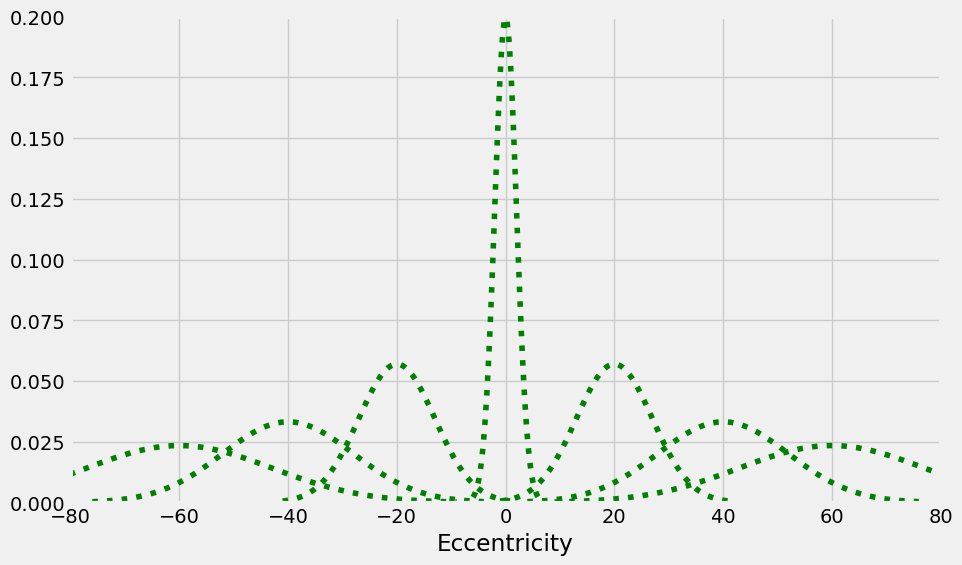

In [4]:

eccentricity = np.arange(-60,70,20)

plt.figure(figsize=(10,6))

for i in eccentricity:
    plot_gaussian(i, fixed_noise+abs(noise_parameter*i), 'g:',f'{i}')

x = plt.xlabel('Eccentricity')

In the figure above it is assumed that the fovea (the gaze location) is at 0 eccentricity. Each distribution then represents the perceived target location probability given that the actual target location is at the centre of the distribution.

So, for example, if the target is at eccentricity 60 then the probability of perceiving it at 60 is about 0.025, whereas if the target is at 20 then the probability of perceiving it at 20 is over 0.05.

Parameter values do not represent the actual human acuity function and are for illustration only.

<p>
<a id='T1'></a>
<div class="alert alert-block alert-success">
<h3>Student Task 1 (optional).</h3>
<br>
    
- Build a Python model of human vision which returns the (stochastic) perceived location of a target given the true location.

- Hint:
    1. Use the numpy function random.uniform() to generate a target location between some lower and upper bound of eccentricity.
    2. Use the eccentricity and the function random.normal() to generate an estimate of the target location.</div>
</p>

In [ ]:
### YOUR CODE HERE ###

<p>
<a id='T2'></a>
<div class="alert alert-block alert-success">
<h3>Student Task 2. (optional) </h3>
<br>
    
- Assume that the eyes are moved to the perceived location and a new observation is made of the target (which has not moved). Show, through simulated trials, how the error in the perceived location reduces as each successive observation is made.

- Explain why the accuracy increases.</div>
</p>

In [ ]:
### YOUR CODE HERE ###



---



# 2. Bayesian estimation <a id='2.'></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jussippjokinen/CogMod-Tutorial/blob/main/02-DeepRL/bayesian_state_estimation.ipynb)




Andrew Howes\
School of Computer Science\
University of Birmingham

What do people do with a sequence of observations (visual or otherwise)? Should they just use the most recent observation? Or perhaps the "best" observation? In fact, people do neither. Multiple sources of evidence suggests that people optimally integrate observations to generate a posterior estimate given all of the available information. One way to model this process is with Bayesian inference.

This notebook gives one simple worked example of Bayesian inference for a human estimating the visual location of a target from a sequence of fixations at a fixed location.


Given a prior location distribution $z_1$ with uncertainty $\sigma^2_{z1}$, the user makes a visual observation $z_2$ with uncertainty  $\sigma^2_{z2}$.

The user combines their prior and observation optimally using Bayesian estimation.

The best estimate, given the prior and observation, is $\mu$ with an associated error variance $ \sigma^2$ as defined below.  

$$ \mu =[\sigma^2_{z_2}/(\sigma^2_{z_1}+\sigma^2_{z_2})] z_1 +[\sigma^2_{z_1}/(\sigma^2_{z_1}+\sigma^2_{z_2})] z_2 $$


$$1/ \sigma^2=1/ \sigma^2_{z_1}+1/ \sigma^2_{z_2} $$

$\sigma$ is less than either $\sigma_{z_1}$ or $\sigma_{z_2}$ , which is to say that the uncertainty in the user's estimate of location has been decreased by combining the two pieces of information (the prior and the observation).

If $\sigma_{z_1}$ were equal to $\sigma_{z_2}$, which is to say that the prior and observation are of equal precision, then the equation says the optimal estimate of position is simply the average of the two measurements, as would be expected. On the other hand, if $\sigma_{z_1}$ were larger than $\sigma_{z_2}$, which is to say that the uncertainty in the prior $z_1$ is greater than that of the observation $z_2$ , then the equation dictates “weighting” $z2$ more heavily than $z1$. Finally, the variance of the estimate is less than $\sigma_{z_1}$ , even if $\sigma_{z_2}$ is very large: even poor quality data provide some information, and should thus increase the precision of the user's estimate.

The above equations can be reformulated.

We have a Guassian prior $p(x)$, and a noisy observation $o$.

The optimal location estimate $\hat{X}$, that is the maximum of the posterior is:

$$\hat{X}=\alpha o +(1- \alpha) \hat{\mu}$$

Where,

$$\alpha=\dfrac{\sigma^2_{p}}{\sigma^2_{p}+\sigma^2_{o}}$$


In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl

import scipy.stats
import numpy as np

mpl.style.use('fivethirtyeight')


def combine_two_guassian(m1,sigma1,m2,sigma2):
    '''
    Optimally combine two gaussians
    Return combine mean and std
    '''
    w1=sigma2**2/(sigma1**2+sigma2**2)
    w2=sigma1**2/(sigma1**2+sigma2**2)

    m=w1*m1+w2*m2
    sigma=np.sqrt( (sigma1**2 * sigma2**2)/(sigma1**2 + sigma2**2))

    return m,sigma

def plot_gaussian(mean,sigma,fmt,label):
    '''
    plot the guassian pdf
    '''
    x_min = mean-3*sigma
    x_max = mean+3*sigma
    x = np.linspace(x_min, x_max, 100)
    y = scipy.stats.norm.pdf(x,mean,sigma)
    plt.xlim(-1,80)
    plt.ylim(0,0.06)
    plt.plot(x,y,fmt,label=label)


Text(0.5, 0, 'Eccentricity')

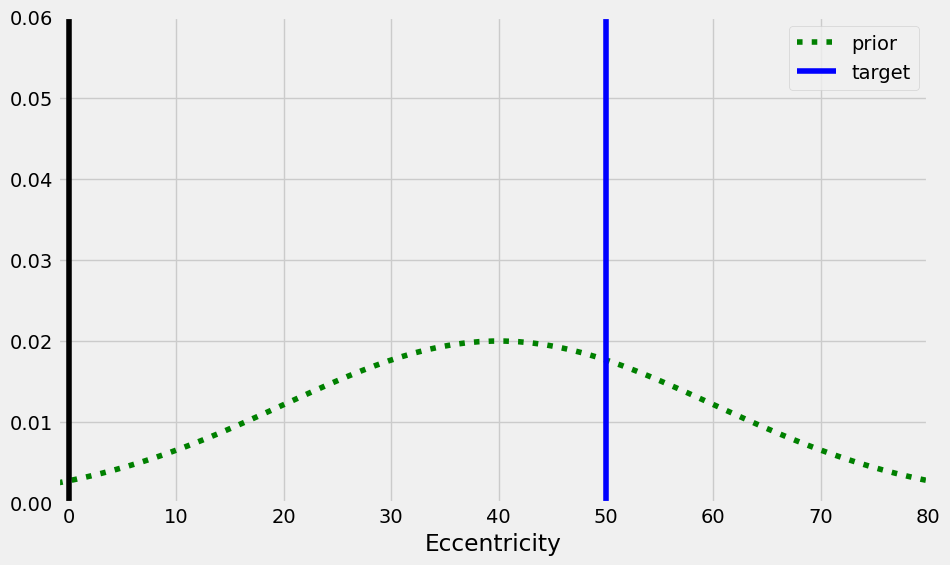

In [6]:
fixation=0
target=50
m1,sigma1=40,20
m2,sigma2=47,10

plt.figure(figsize=(10,6))
# obs 1

plot_gaussian(m1,sigma1,'g:','prior')

# plot the target line and fixation line
plt.axvline(x = target, color = 'b', label = 'target')
plt.axvline(x = fixation, color = 'k')

plt.legend(loc='best')
plt.xlabel('Eccentricity')


Text(0.5, 0, 'Eccentricity')

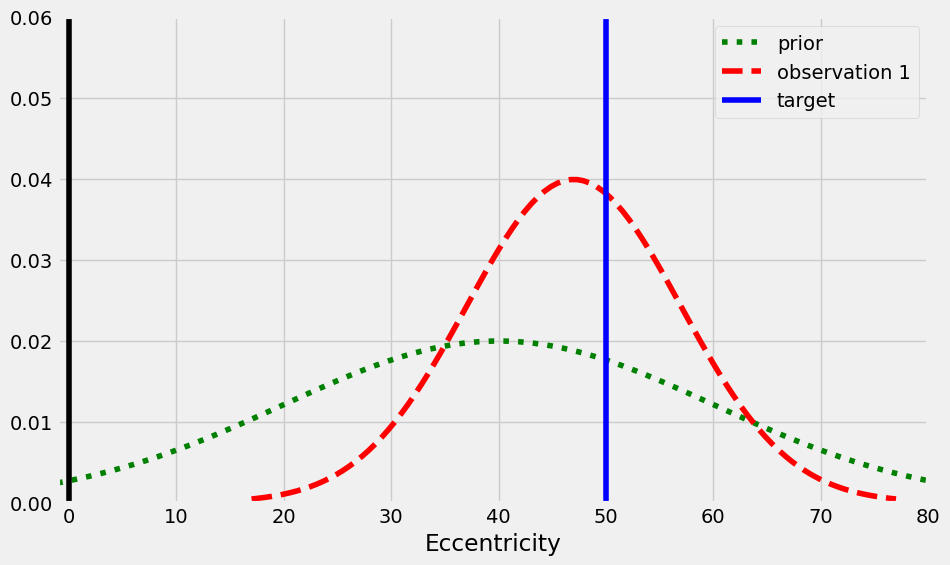

In [7]:


plt.figure(figsize=(10,6))
# obs 1

plot_gaussian(m1,sigma1,'g:','prior')

# obs 2

plot_gaussian(m2,sigma2,'r--','observation 1')


# plot the target line and fixation line
plt.axvline(x = target, color = 'b', label = 'target')
plt.axvline(x = fixation, color = 'k')

plt.legend(loc='best')
plt.xlabel('Eccentricity')



45.6
8.94427190999916


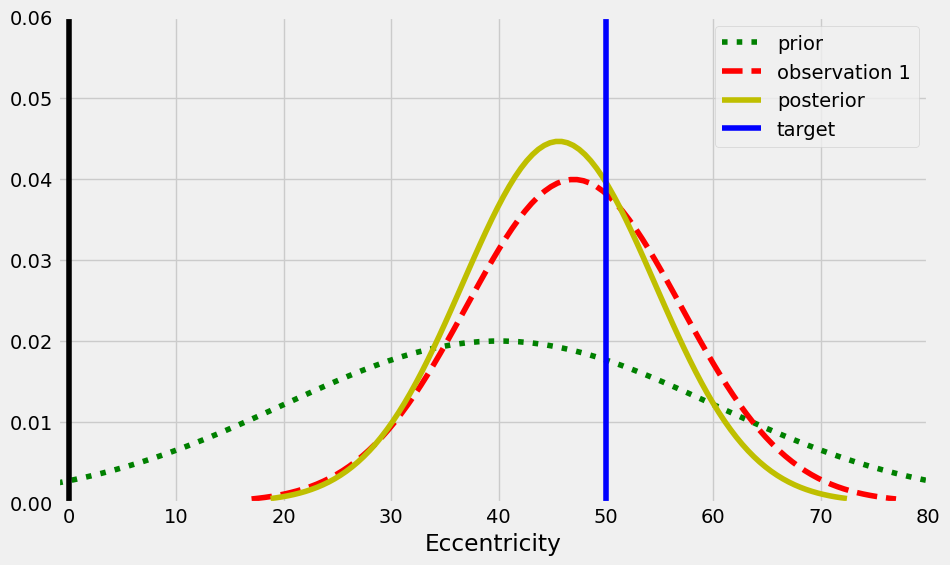

In [8]:
fixation=0
target=50

plt.figure(figsize=(10,6))
# obs 1

plot_gaussian(m1,sigma1,'g:','prior')

# obs 2

plot_gaussian(m2,sigma2,'r--','observation 1')

# combine obs1 and obs2
m3,sigma3=combine_two_guassian(m1,sigma1,m2,sigma2)
plot_gaussian(m3,sigma3,'y-','posterior')

# plot the target line and fixation line
plt.axvline(x = target, color = 'b', label = 'target')
plt.axvline(x = fixation, color = 'k')

plt.legend(loc='best')
plt.xlabel('Eccentricity')

print(m3)
print(sigma3)


<p>
<a id='T3'></a>
<div class="alert alert-block alert-success">
<h3>Student Task 3 (optional).</h3>
<br>
    
- Try different values of the mean and variance of the distributions. Satisfy yourself that the posterior estimate is always more accurate than the prior and the observation.
- Given a prior with standard deviation of 20 and mean 40, imagine three observations each with different standard deviation (5,10,15) but the same location (70). Illustrate the effect of each observation on the posterior.
- Write a function that takes as input a sequences of noisy observations, possibly from foveated vision(!), of arbitrary length and generates a posterior estimate of the target location. This will be your first simple model of human vision.


</div>
</p>

1. Try different values of the mean and variance of the distributions. Satisfy yourself that the posterior estimate is always more accurate than the prior and the observation.

In [9]:
## Hint : You can use this function. ###
def show_posterior(m1, sigma1, m2, sigma2):
    fixation=0
    target=50

    plt.figure(figsize=(10,6))
    plot_gaussian(m1,sigma1,'g:','prior')
    plot_gaussian(m2,sigma2,'r--','observation 1')

    m3,sigma3=combine_two_guassian(m1,sigma1,m2,sigma2)
    plot_gaussian(m3,sigma3,'y-','posterior')

    plt.axvline(x = target, color = 'b', label = 'target')
    plt.axvline(x = fixation, color = 'k')

    plt.legend(loc='best')
    plt.xlabel('Eccentricity')

    print(m3)
    print(sigma3)


In [10]:
### YOUR CODE HERE ###

2. Given a prior with standard deviation of 20 and mean 40, imagine three observations each with different standard deviation (5,10,15) but the same location (70). Illustrate the effect of each observation on the posterior.

In [11]:
### YOUR CODE HERE ###


### Advanced

3. Write a function that takes as input a sequences of noisy observations, possibly from foveated vision(!), of arbitrary length and generates a posterior estimate of the target location. This will be your first simple model of human vision.


In [12]:
### YOUR CODE HERE ###



---



# 3. Cognitive model <a id='3.'></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jussippjokinen/CogMod-Tutorial/blob/main/02-DeepRL/Gaze_Based_Interaction/gaze_based_interaction.ipynb)


## 3.1. A cognitive model of gaze-based interaction

Some cognitive models describe behaviour and others predict it. Models that predict behaviour must be capable of generating output without that output being part of the input. In this notebook we demonstrate this property for a model of eye movements. The model is a reinforcement learner that is trained by performing hundreds of thousands of simulated eye movements in search of a target of varying size and distance. The model predicts how many eye movements people will tend to make to find a target of a given size and distance. It predicts inhibition of return. It **predicts** Fitts's Law like behaviour and it predicts that the first eye movement will usually undershoot, rather than overshoot the target.

<img src="https://raw.githubusercontent.com/howesa/CHI22-CogMod-Tutorial/main/03-Reinforcement-Learning/034_Gaze_based_Interaction/image/sub_movements.png" alt="Corati Modeling" width="400">

(source: Meyer, D. E., Abrams, R. A., Kornblum, S., Wright, C. E., & Keith Smith, J. E. (1988). Optimality in human motor performance: ideal control of rapid aimed movements. Psychological review, 95(3), 340.)

Note that what might seem the obvious strategy -- aim for where you believe the target is -- is not necessarily the optimal strategy.

### 3.1.1 The task: Gaze-based interaction

Gaze-based interaction is a mode of interaction in which users, including users with a range of movement disabilities, are able to indicate which display item they wish to select by fixating their eyes on it. Confirmation of selection is then made with one of a number of methods, including with a key press, or by holding the fixation for an extended duration of time. The model performs this task for targets with randomly selected location and size.

<img src="https://raw.githubusercontent.com/howesa/CHI22-CogMod-Tutorial/main/03-Reinforcement-Learning/034_Gaze_based_Interaction/image/gaze_task.png" alt="Corati Modeling" width="400">

In the figure, the red lines represent saccades (eye movements). Multiple eye movements are needed to reach the target (the black circle).

### 3.1.2 Model architecture

The model has a simple architecture that you have previously seen in the introduction. The figure is reproduced here:

<img src="https://raw.githubusercontent.com/howesa/CHI22-CogMod-Tutorial/main/03-Reinforcement-Learning/034_Gaze_based_Interaction/image/cog_arch.png" alt="Corati Modeling" width="700">

- The **control** module makes decisions about where to move the eyes with the oculomotor system. Decisions are conditioned on the current belief about the location of the target.
- The **motor** module implements decisions but it is bounded by Gaussian noise, which models noise in the human motor system.
- The **environment** models the physics of the world and the task (the location of the target). Given a response from the motor system, a saccade is made to the aim point of the eyes, and a fixation is initiated.
- The **perception** module simulates the human capacity to localize a target with foveated vision. The accuracy of the location estimate generated by perception is negatively affected by the eccentricity of the target from the current fixation location.
- The **Memory** module stores a representation of the current state. Over the course of an episode a sequence of location estimates will be made. Humans are known to integrate these estimates into a single integrated representation of the location. People are known to do this optimally using a process that can be modelled with Bayesian state estimation. The state estimation constitutes a belief about the location of the target.
- The **Utility** module calculates a reward signal given the current belief about the enviornment. The reward signal is used to train the controller.

### 3.1.3 Prerequisites

Before proceeding with this notebook you should first review the notebooks on foveated vision and on Bayesian integration. These explain how the perception and memory modules work.



## 3.2. Machine learning

In order to learn how to perform the task, the model uses implementations of reinforcement learning algorithms in PyTorch known as stable-baselines3.

In [13]:
# Install stable_baselines3 and the gymnasium environment
# This is a well known machine learning library that provides a suite of reinforcement learning methods.
# Only needs to be run once

!pip install --pre -U stable_baselines3

import gymnasium as gym
from gymnasium import spaces

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.7/183.7 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 57.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906.4 MB 1.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 42.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 53.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 23.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━

In [14]:
# Load local modules
# gazetools is a module that contains support functions for modeling gaze-based interaction.
# the code below makes use of them but we do not need to understand how they work in this tutorial.

!wget https://raw.githubusercontent.com/jussippjokinen/CogMod-Tutorial/main/02-DeepRL/Gaze_Based_Interaction/gazetools.py
!wget -P /content/output https://raw.githubusercontent.com/jussippjokinen/CogMod-Tutorial/main/02-DeepRL/Gaze_Based_Interaction/output/monitor.csv

import gazetools

--2024-11-25 18:00:51--  https://raw.githubusercontent.com/jussippjokinen/CogMod-Tutorial/main/02-DeepRL/Gaze_Based_Interaction/gazetools.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5204 (5.1K) [text/plain]
Saving to: ‘gazetools.py.13’

gazetools.py.13     100%[===================>]   5.08K  --.-KB/s    in 0s      

2024-11-25 18:00:51 (43.3 MB/s) - ‘gazetools.py.13’ saved [5204/5204]

--2024-11-25 18:00:51--  https://raw.githubusercontent.com/jussippjokinen/CogMod-Tutorial/main/02-DeepRL/Gaze_Based_Interaction/output/monitor.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.


2024-11-25 18:00:56.314060: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
# load required standard modules and configure matplotlib

import numpy as np
import math
import matplotlib.pyplot as plt
import sys

import matplotlib as mpl
%matplotlib inline
mpl.style.use('ggplot')

## 3.3. Implementation of the Cognitive Architecture as a Python Class

The first step to formalise the model architecture presented in the above figure. We do this by specifying a class of cognitive theories and will later define an instance of this class.

The class has only a single method, which defines a cycle through the processes defined in the figure.

In [16]:
class CognitivePOMDP():

    def __init__(self):
        self.internal_state = {}

    def step(self, ext, action):
        ''' Define the cognitive architecture.'''
        self._update_state_with_action(action)
        response = self._get_response()
        external_state, done = ext.external_env(response)
        stimulus, stimulus_std = self._get_stimulus(ext.external_state)
        self._update_state_with_stimulus(stimulus, stimulus_std)
        obs = self._get_obs()
        reward = self._get_reward()
        return obs, reward, done

## 3.4. A theory of gaze-based interaction

Each of the entities in the cognitive architecture must be defined so as to make explicit our theory of gaze-based interaction. The theory makes the following assumptions:

- The perception of the target location is corrupted by Gaussian noise in human vision.
- The standard deviation of noise increases linearly with eccentricity from the fovea.
- Sequences of stimuli are noisily perceived and optimally integrated.
- Intended eye movements (oculomotor actions) are corrupted by signal dependent Gaussian noise to generate responses.

These assumptions are further described in Chen et al. (2021).

In [17]:
class GazeTheory(CognitivePOMDP):

    def __init__(self):
        ''' Initialise the theoretically motivated parameters.'''
        # weight eye movement noise with distance of saccade
        self.oculamotor_noise_weight = 0.01
        # weight noise with eccentricity
        self.stimulus_noise_weight = 0.09
        # step_cost for the reward function
        self.step_cost = -1
        # super.__init__()

    def reset_internal_env(self, external_state):
        ''' The internal state includes the fixation location, the latest estimate of
        the target location and the target uncertainty. Assumes that there is no
        uncertainty in the fixation location.
        Assumes that width is known. All numbers are on scale -1 to 1.
        The target_std represents the strength of the prior.'''
        self.internal_state = {'fixation': np.array([-1,-1]),
                               'target': np.array([0,0]),
                               'target_std': 0.1,
                               'width': external_state['width'],
                               'action': np.array([-1,-1])}
        return self._get_obs()

    def _update_state_with_action(self, action):
        self.internal_state['action'] = action

    def _get_response(self):
        ''' Take an action and add noise.'''
        # !!!! should take internal_state as parameter
        move_distance = gazetools.get_distance( self.internal_state['fixation'],
                                     self.internal_state['action'] )

        ocularmotor_noise = np.random.normal(0, self.oculamotor_noise_weight * move_distance,
                                        self.internal_state['action'].shape)
        # response is action plus noise
        response = self.internal_state['action'] + ocularmotor_noise

        # update the ocularmotor state (internal)
        self.internal_state['fixation'] = response

        # make an adjustment if response is out of range.
        response = np.clip(response,-1,1)
        return response

    def _get_stimulus(self, external_state):
        ''' define a psychologically plausible stimulus function in which acuity
        falls off with eccentricity.'''
        eccentricity = gazetools.get_distance( external_state['target'], external_state['fixation'] )
        stm_std = self.stimulus_noise_weight * eccentricity
        stimulus_noise = np.random.normal(0, stm_std,
                                         external_state['target'].shape)
        # stimulus is the external target location plus noise
        stm = external_state['target'] + stimulus_noise
        return stm, stm_std


    def _update_state_with_stimulus(self, stimulus, stimulus_std):
        posterior, posterior_std = self.bayes_update(stimulus,
                                                     stimulus_std,
                                                     self.internal_state['target'],
                                                     self.internal_state['target_std'])
        self.internal_state['target'] = posterior
        self.internal_state['target_std'] = posterior_std

    def bayes_update(self, stimulus, stimulus_std, belief, belief_std):
        ''' A Bayes optimal function that integrates multiple stimului.
        The belief is the prior.'''
        z1, sigma1 = stimulus, stimulus_std
        z2, sigma2 = belief, belief_std
        w1 = sigma2**2 / (sigma1**2 + sigma2**2)
        w2 = sigma1**2 / (sigma1**2 + sigma2**2)
        posterior = w1*z1 + w2*z2
        posterior_std = np.sqrt( (sigma1**2 * sigma2**2)/(sigma1**2 + sigma2**2) )
        return posterior, posterior_std

    def _get_obs(self):
        # the Bayesian posterior has already been calculated so just return it.
        # also return the target_std so that the controller knows the uncertainty
        # of the observation.
        #return self.internal_state['target']
        return np.array([self.internal_state['target'][0],
                        self.internal_state['target'][1],
                        self.internal_state['target_std']])

    def _get_reward(self):
        distance = gazetools.get_distance(self.internal_state['fixation'],
                                self.internal_state['target'])

        if distance < self.internal_state['width'] / 2:
            reward = 0
        else:
            reward = -distance # a much better model of the psychological reward function is possible.

        return reward

## 3.5. Task environment

In order to test the theory we need to define the task environment.

The task environment allows the theory to make predictions for a particular task. The theory makes predictions for many more tasks. For example, adaptation to mixed target widths and distances.

In [18]:
class GazeTask():

    def __init__(self, target_width = 0.15):
        self.target_width = target_width
        self.target_loc_std = 0.3

    def reset_external_env(self):
        ''' The external_state includes the fixation and target location.
        Choose a new target location and reset fixation to the first fixation location.'''

        def _get_new_target():
            x_target =np.clip(np.random.normal(0, self.target_loc_std),-1,1)
            y_target =np.clip(np.random.normal(0, self.target_loc_std),-1,1)
            return np.array( [x_target, y_target] )

        fx = np.array([-1,-1])
        tg = _get_new_target()
        self.external_state = {'fixation':fx, 'target':tg, 'width':self.target_width }

    def external_env(self, action):
        self.external_state['fixation'] = action

        # determine when the goal has been achieved.
        distance = gazetools.get_distance(self.external_state['fixation'],
                                self.external_state['target'])
        if distance < self.external_state['width']/2 :
            done = True
        else:
            done = False

        return self.external_state, done


The following code shows the visualization of the task environment with three random target points.

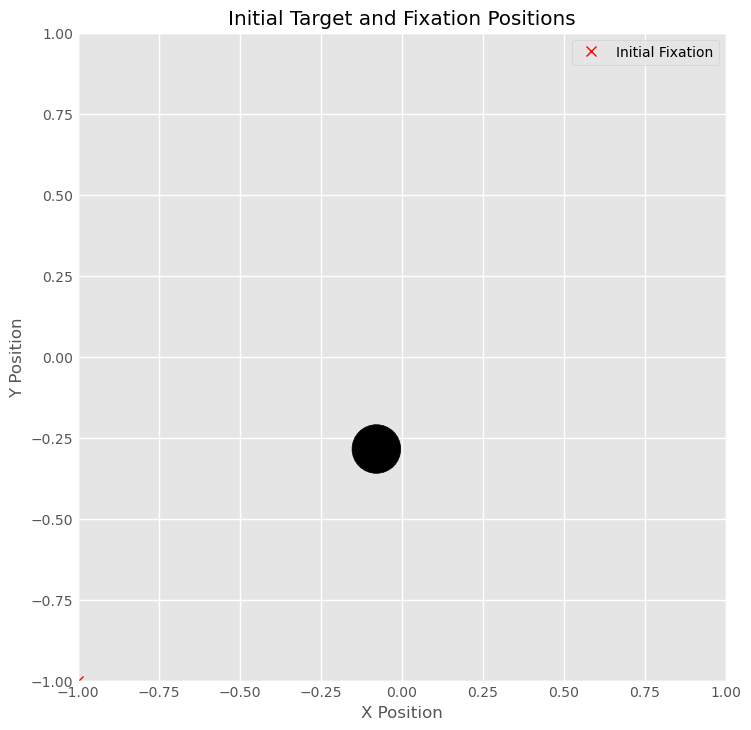

Initial Fixation Location: [-1 -1]
Target Location: [-0.0792394  -0.28528037]
Target Width: 0.15






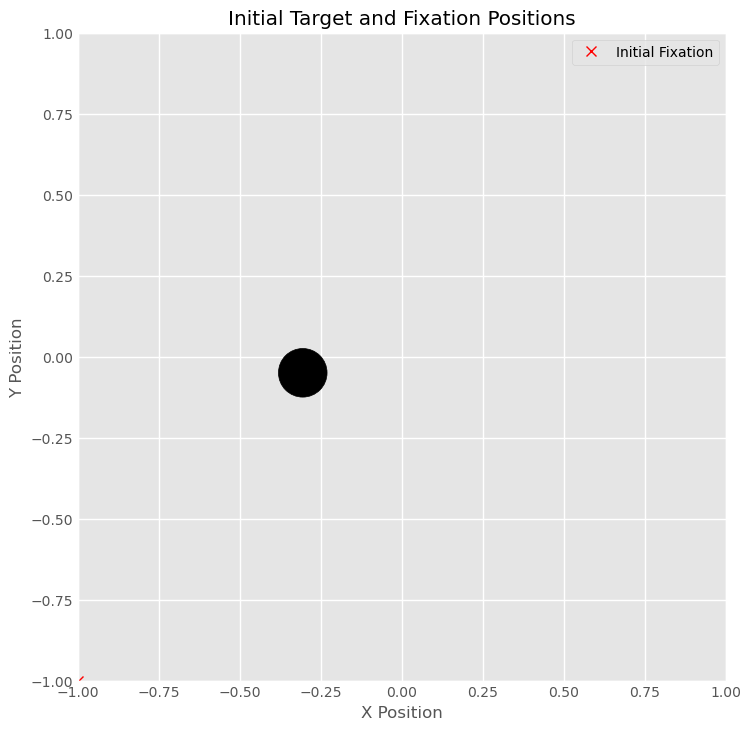

Initial Fixation Location: [-1 -1]
Target Location: [-0.3064377  -0.05005517]
Target Width: 0.15






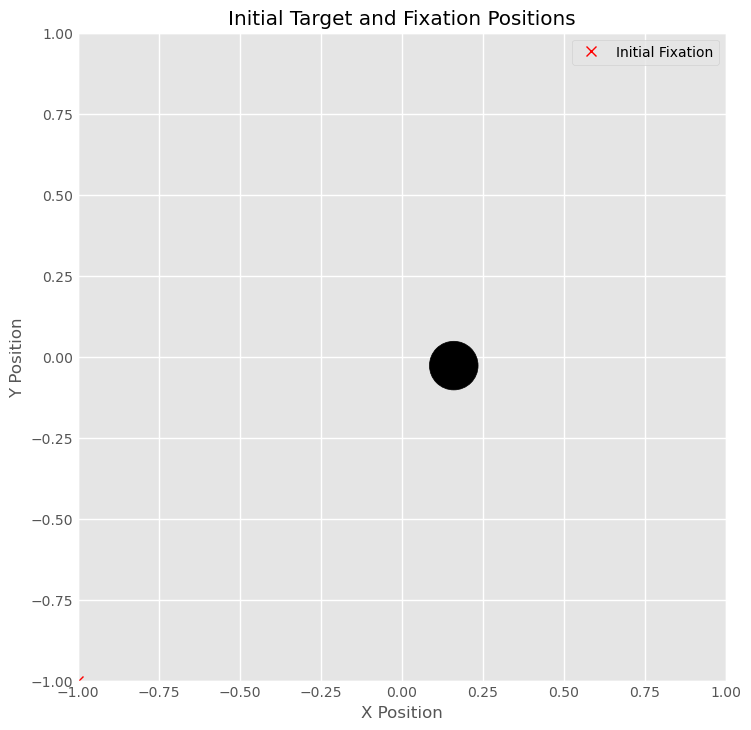

Initial Fixation Location: [-1 -1]
Target Location: [ 0.15962063 -0.02782849]
Target Width: 0.15






In [19]:
def visualize_gaze_task():

    task_env = GazeTask(target_width=0.15)
    task_env.reset_external_env()
    initial_state = task_env.external_state

    plt.figure(figsize=(8,8))
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.gca().set_aspect('equal', adjustable='box')

#######
    target = initial_state['target']
    target_width = initial_state['width']
    circle = plt.Circle((target[0],target[1]), target_width/2, color='k')
    plt.gca().add_patch(circle)


    fixation = initial_state['fixation']
    plt.plot(fixation[0], fixation[1], 'rx', markersize=7, label='Initial Fixation')

    plt.legend()
    plt.title('Initial Target and Fixation Positions')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.show()

    print("Initial Fixation Location:", initial_state['fixation'])
    print("Target Location:", initial_state['target'])
    print("Target Width:", initial_state['width'])

#######
visualize_gaze_task()
print('\n' * 3)
visualize_gaze_task()
print('\n' * 3)
visualize_gaze_task()
print('\n' * 3)

We then combine the **GazeTheory with the Task environment** and plot the changes in gaze position over multiple simulation steps to show the eye movement process. **(Please note that random actions are used here just to test how it works.)**


####### Step 1 #########
Observation: [-0.06144774  0.11410888  0.04719003]
Reward: -0.5954644373297197
Done: False
Internal State: {'fixation': array([-0.65179935,  0.03624443]), 'target': array([-0.06144774,  0.11410888]), 'target_std': 0.047190033309412655, 'width': 0.15, 'action': array([-0.66436771,  0.04076602])}

####### Step 2 #########
Observation: [-0.0976965   0.14704152  0.03403995]
Reward: -0.5725723923475116
Done: False
Internal State: {'fixation': array([0.47005522, 0.07289888]), 'target': array([-0.0976965 ,  0.14704152]), 'target_std': 0.0340399457982638, 'width': 0.15, 'action': array([0.49103846, 0.07398754])}

####### Step 3 #########
Observation: [-0.09869503  0.16031086  0.02309297]
Reward: -0.3198993381351329
Done: False
Internal State: {'fixation': array([-0.41747471,  0.18705232]), 'target': array([-0.09869503,  0.16031086]), 'target_std': 0.02309296773554763, 'width': 0.15, 'action': array([-0.42029   ,  0.18330588])}

####### Step 4 #########
Observation: [-

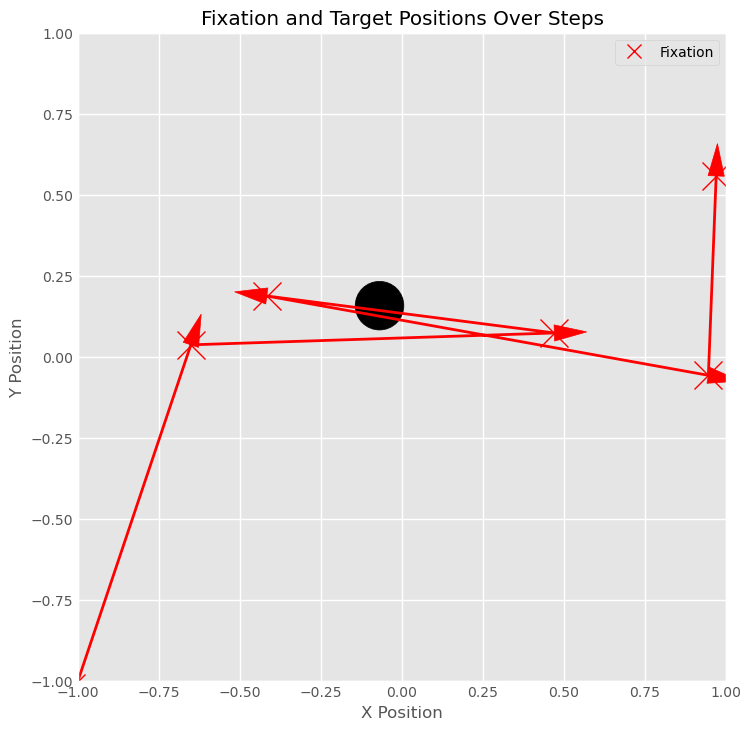

In [20]:
def visualize_gaze_theory_steps(steps):
    gaze_theory = GazeTheory()
    task_env = GazeTask(target_width=0.15)
    task_env.reset_external_env()
    gaze_theory.reset_internal_env(task_env.external_state)

    plt.figure(figsize=(8, 8))
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.gca().set_aspect('equal', adjustable='box')

    target = task_env.external_state['target']
    target_width = task_env.external_state['width']

    circle = plt.Circle((target[0], target[1]), target_width / 2, color='k')
    plt.gca().add_patch(circle)

    fixation = task_env.external_state['fixation']
    plt.plot(fixation[0], fixation[1], 'rx', markersize=10, label='Fixation')


    fixations = [fixation]

    for i in range(steps):
        action = np.random.uniform(-1, 1, 2)  # Random action
        obs, reward, done = gaze_theory.step(task_env, action)
        fixation = gaze_theory.internal_state['fixation']

        fixations.append(fixation)

        plt.plot(fixation[0], fixation[1], 'rx', markersize=20)
        plt.arrow(fixations[-2][0], fixations[-2][1], fixation[0] - fixations[-2][0], fixation[1] - fixations[-2][1],
                  head_width=0.05, head_length=0.1, fc='r', ec='r')

        print(f"\n####### Step {i+1} #########")
        print("Observation:", obs)
        print("Reward:", reward)
        print("Done:", done)
        print("Internal State:", gaze_theory.internal_state)

        if done:
            break


    fixations = np.array(fixations)

    plt.plot(fixations[:, 0], fixations[:, 1], 'r-', linewidth=2)
    plt.legend()
    plt.title('Fixation and Target Positions Over Steps')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.show()

visualize_gaze_theory_steps(steps=5)


## 3.6. Gym (Gymnasium)

In order to find an optimal policy we use the theory and external environment to define a machine learning problem, here, making use of the framework defined by one specific library called gym.

For further information see: https://gymnasium.farama.org/

gym.Env is a class provided by this library. Note that all of the modules of the cognitive architecture are part of gym.env except for the controller.

In [21]:
class GazeModel(gym.Env):

    def __init__(self, target_width = 0.15):

        def default_box(x):
            return spaces.Box(low=-1, high=1, shape=(x, ), dtype=np.float64)

        self.GT = GazeTheory()
        self.TX = GazeTask(target_width)

        # Required by gym. These define the range of each variable.
        # Each action has an x,y coordinate therefore the box size is 2.
        # Each obs has a an x,y and an uncertainty therefore the box size is 3.
        self.action_space = default_box(2)
        self.observation_space = default_box(3)

        # max_fixations per episode. Used to curtail exploration early in training.
        self.max_steps = 500

    def reset(self, seed=None, options=None):
        ''' reset the model.'''
        self.n_step = 0
        self.TX.reset_external_env()
        self.GT.reset_internal_env(self.TX.external_state)
        obs = self.GT.reset_internal_env( self.TX.external_state )
        return obs, {}

    def step(self, action):
        ''' Step through one cycle of the model.'''
        obs, reward, done = self.GT.step( self.TX, action )
        self.n_step+=1

        # give up if been looking for too long
        if self.n_step > self.max_steps:
            done = True

        info = self.get_info()
        truncated = False
        return obs, reward, done, truncated, info

    def get_info(self):
        return {'step': self.n_step,
                'target_width': self.TX.target_width,
                'target_x': self.TX.external_state['target'][0],
                'target_y': self.TX.external_state['target'][1],
                'fixate_x':self.TX.external_state['fixation'][0],
                'fixate_y':self.TX.external_state['fixation'][1] }

## 3.7. Test the model

Step through the untrained model to check for simple bugs. More comprehensive tests needed.

In [22]:
model = GazeModel()

model.reset()

i=0
done = False
while not done:
    # make a step with a randomly sampled action
    obs, reward, done, truncated, info = model.step(model.action_space.sample())
    i+=1

print(i)

109


## 3.8. Train the model

We can train the model to generate a policy for the controller.

By plotting the learning curve we can see whether the performance improves with training and whether the model approaches an optimum performance. We are interested in approximately optimal performance, so if the training curve is not approaching asymptote then we need to train with more timesteps or revise the model.

We can see that at first the model uses hundreds of fixations to find the target, this is because it has not yet learned to move the gaze in a way that is informed by the observation. As it learns to do this, it takes fewer steps to gaze at the target and its performance improves.

If our problem definition is correct then the model will get more 'human-like' the more that it is trained. In other words, training makes it a better model of interaction.

If we assume that people are computationally rational then the optimal solution to a cognitive problem predicts human behavior.

In [23]:
timesteps = 100000

controller = gazetools.train(model, timesteps)

Done training.


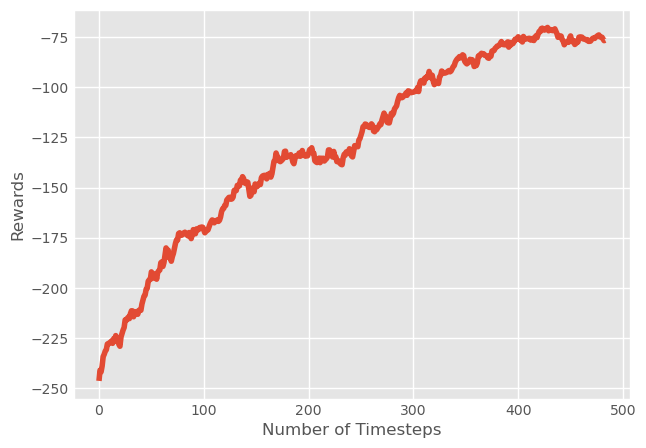

In [24]:
gazetools.plot_learning_curve()

### Increase timesteps

100,000 timesteps is not enough to train this model. Try doubling the number of timesteps and train again.

## 3.9. Run the model for N trials
Run the trained model, save a trace of each episode to csv file, and animate the results.

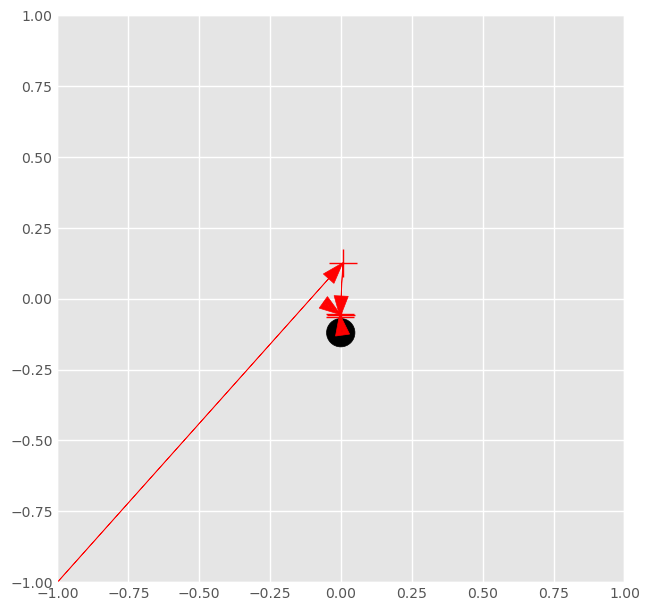

In [25]:
model = GazeModel(target_width = 0.1) # You can change the parameter 'target_width'.

data = gazetools.run_model( model, controller, 100, 'behaviour_trace.csv' )

gazetools.animate_multiple_episodes(data, n=30)

<p>
<a id='T4'></a>
<div class="alert alert-block alert-success">
<h3>Exercise.</h3>

**Predictions.** Let's first look at what kind of predictions we can generate with the model.

A. First, generate data for different target widths using GazeModel (you can change the widths in the code template below). Also generate some movement times. Movement time is the total time required to move the eyes to the target. We assume that the movement duration is the sum of (1) the saccades and (2) the fixations. A helper function ```add_movement_time``` is given for a rough estimate. What do each of the rows in the generated dataset represent?
    
B. How do movement times and number of fixations predicted by GazeModel change depending on target width? Plot.
    
</div>
</p>

To help you get started, the below function randomly samples some movement times.

In [26]:
def add_movement_time(data):
    data["fixation_duration"] = np.random.uniform(0.1, 1, size=len(data))
    data["saccade_duration"] = np.random.uniform(0.01, 0.2, size=len(data))
    
    return data

In [27]:
datas = []
for target_width in [0.1, 0.15, 0.2, 0.3, 0.4]: # Change widths here
    model = GazeModel(target_width = target_width) # You can change the parameter 'target_width'.
    data = gazetools.run_model( model, controller, 100, 'behaviour_trace.csv' )
    datas.append(data)

In [28]:
data = pd.concat(datas)
data = add_movement_time(data)

In [29]:
data

,step,target_width,target_x,target_y,fixate_x,fixate_y,episode,fixation_duration,saccade_duration
0,0,0.1,0.218247,0.247766,-1.000000,-1.000000,0,0.144834,0.049851
1,1,0.1,0.218247,0.247766,0.037846,0.127668,0,0.530107,0.148820
2,2,0.1,0.218247,0.247766,0.307843,0.473778,0,0.807421,0.010666
3,3,0.1,0.218247,0.247766,0.326173,0.459806,0,0.103692,0.169246
4,4,0.1,0.218247,0.247766,0.333668,0.435276,0,0.915334,0.122568
...,...,...,...,...,...,...,...,...,...
310,1,0.4,-0.110800,-0.041523,0.053821,0.123692,98,0.158866,0.188704
311,2,0.4,-0.110800,-0.041523,-0.125055,0.050592,98,0.585245,0.141727
312,0,0.4,-0.051058,-0.139001,-1.000000,-1.000000,99,0.625332,0.062061
313,1,0.4,-0.051058,-0.139001,0.015378,0.124946,99,0.291111,0.196125


In [37]:
def aggregate_movement_time(data):
    # Group data by episode index and calculate total movement time
    data["movement_duration"] = data["fixation_duration"] + data["saccade_duration"]
    return (
        data.groupby(["target_width", "episode_index"])["movement_duration"]
        .sum()
        .reset_index(name="total_movement_time")
    )

# List of target widths to test
target_widths = [0.1, 0.2, 0.3, 0.4]

# Store data from all target widths
datas = []

for target_width in target_widths:
    model = GazeModel(target_width=target_width)
    data = gazetools.run_model(model, controller, 100, "behaviour_trace.csv")
    data["target_width"] = target_width  # Add a column for target width
    if "episode_index" not in data.columns:
        data["episode_index"] = data.index // len(data)
    datas.append(data)

# Combine all data
data = pd.concat(datas)

# Add movement time columns
data = add_movement_time(data)

# Aggregate total movement time for each trial (episode)
movement_time_summary = aggregate_movement_time(data)

print(movement_time_summary)

   target_width  episode_index  total_movement_time
0           0.1              0         28014.687957
1           0.2              0         12574.288906
2           0.3              0          4773.949123
3           0.4              0           515.035159


<p>
<a id='T4'></a>
<div class="alert alert-block alert-success">
<h3>Exercise.</h3>

**GazeModel vs. Fitts' law.** Let's compare the model to Fitts' law.
    
C. Calculate an index of difficulty (ID) for each generated target-distance pair. Use Fitts' law to generate movement times.  
    
D. Plot ID vs. movement time for different target widths using Fitts' law to predict movement times. Plot ID vs. movement time for different target widths using GazeModel to predict movement times.

E. How do the predictions from Fitts' law and GazeModel compare? 
    
</div>
</p>

The relevant functions for Fitts' law are also provided below:

In [31]:
# Fitts' law related functions
def fitts(ID, a, b):
    return a + b * ID

def ID(ddata, wdata):
    return np.log(ddata/wdata+1)

In [32]:
##### ADD YOUR ANSWER HERE #######

# Steps that you might want to include...

# Group the data to get movement times per episode

# Add movement time

# Calculate target distance

# Add ID

# Predict search times using Fitts' law

# Plot


# A5a - code

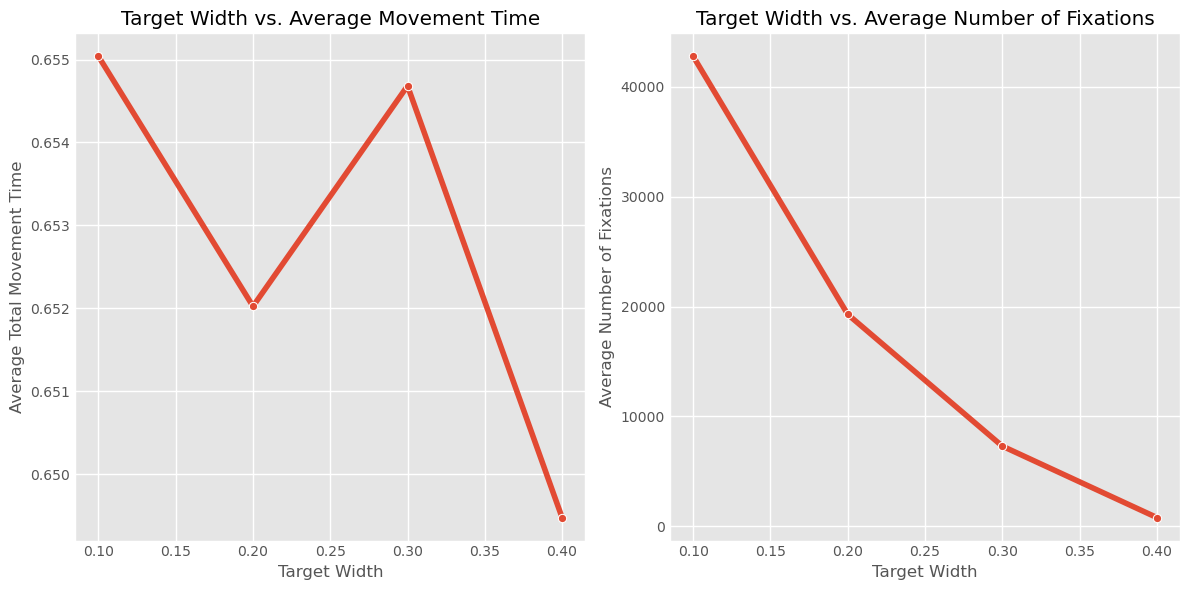

In [38]:
## Part 2
import matplotlib.pyplot as plt
import seaborn as sns

# Compute averages for movement time and fixations
summary = data.groupby("target_width").agg(
    avg_movement_time=("movement_duration", "mean"),
    avg_fixations=("fixation_duration", "count")
).reset_index()

# Plot: Target Width vs. Average Movement Time
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.lineplot(data=summary, x="target_width", y="avg_movement_time", marker="o")
plt.title("Target Width vs. Average Movement Time")
plt.xlabel("Target Width")
plt.ylabel("Average Total Movement Time")
plt.grid(True)

# Plot: Target Width vs. Average Number of Fixations
plt.subplot(1, 2, 2)
sns.lineplot(data=summary, x="target_width", y="avg_fixations", marker="o")
plt.title("Target Width vs. Average Number of Fixations")
plt.xlabel("Target Width")
plt.ylabel("Average Number of Fixations")
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()

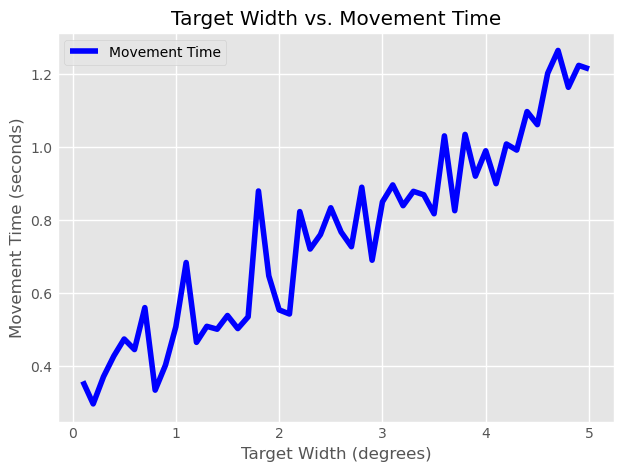

In [40]:
## Part 3 & 4
import numpy as np

saccade_speed = 500  # mm/s

def calculate_saccade_time(fixation, target):
    distance = np.linalg.norm(fixation - target)
    
    # Convert distance to mm (assuming 1 degree = 10 mm at the fixation point)
    distance_mm = distance * 10
    
    saccade_time = distance_mm / saccade_speed # in seconds
    return saccade_time

def add_movement_time(fixation, target, eccentricity_weight=0.1):
    saccade_time = calculate_saccade_time(fixation, target)
    
    # Simulate fixation duration based on eccentricity
    eccentricity = np.linalg.norm(fixation - target)
    
    # Simulate fixation duration with some random variation
    fixation_duration = np.random.normal(loc=0.3 + eccentricity_weight * eccentricity, scale=0.1)  # 0.3s base fixation time
    
    # Ensure that the fixation duration is not negative
    fixation_duration = max(fixation_duration, 0.05)  # minimum fixation duration of 50ms
    
    total_movement_time = saccade_time + fixation_duration
    return total_movement_time, saccade_time, fixation_duration

# Tnge of target widths
target_widths = np.linspace(0.1, 5, 50)  # Target width from 0.1 to 5 degrees
movement_times = []

# Fixation point
fixation = np.array([0, 0])


for width in target_widths:
    target = np.array([width, width])  # Just for simplicity, we place the target diagonally
    total_movement_time, _, _ = add_movement_time(fixation, target)
    movement_times.append(total_movement_time)

# Plots
plt.plot(target_widths, movement_times, label='Movement Time', color='blue')
plt.xlabel('Target Width (degrees)')
plt.ylabel('Movement Time (seconds)')
plt.title('Target Width vs. Movement Time')
plt.grid(True)
plt.legend()
plt.show()


# 4. Discussion <a id='4.'></a>

- The cognitive model that we have described above accurately predicts human gaze-based interaction performance (Chen et al., 2021).
- It is an example of a **computationally rational** cognitive model. This is because the behaviour is predicted from an approximately optimal policy given hypothesised bounds on cognition.
- It should be possible to find an approximately optimal policy using any reinforcement learning algorithm.  The only difference that the algorithm will make is to the efficiency with which solution is found.
- The separation of cognitive theory and reinforcement learning algorithm is achieved through the statement of the architecture as what is known as a belief-state Markov Decision Process (a **belief-state MDP**), which is a type of Partially Observable Markov Decision Process (POMDP).
- Using reinforcement learning (RL) to model cognition with the approximately optimal policy contrast does not model the human learning process. For work that does use RL to model human learning see Daw and Dayan (2008).
- A number of CHI papers have made use of this architecture. See Oulasvirta et al., 2022 for a review.
- An important issue concerns how model parameters are fitted to data. See Keuralinen et al., 2023.

# 5. References <a id='5.'></a>
Chen, X., Acharya, A., Oulasvirta, A., & Howes, A. (2021, May). An adaptive model of gaze-based selection. In Proceedings of the 2021 CHI Conference on Human Factors in Computing Systems (pp. 1-11).

Chen, H., Chang, H. J., & Howes, A. (2021, May). Apparently Irrational Choice as Optimal Sequential Decision Making. In Proceedings of the AAAI Conference on Artificial Intelligence (Vol. 35, No. 1, pp. 792-800).

Dayan, P., & Daw, N. D. (2008). Decision theory, reinforcement learning, and the brain. Cognitive, Affective, & Behavioral Neuroscience, 8(4), 429-453.

Oulasvirta, A., Jokinen, J. P., & Howes, A. (2022, April). Computational rationality as a theory of interaction. In Proceedings of the 2022 CHI Conference on Human Factors in Computing Systems (pp. 1-14).

Keurulainen, A., Westerlund, I. R., Keurulainen, O., & Howes, A. (2023, April). Amortised Experimental Design and Parameter Estimation for User Models of Pointing. In Proceedings of the 2023 CHI Conference on Human Factors in Computing Systems (pp. 1-17).

Ignore this block. This is for Maunal Grading for your report